# Esercizio 5: Atomo di Idrogeno - Metropolis

##### Indice
- Equilibrazione
- Taglia dei blocchi
- Stima di $\langle r \rangle$
- Visualizzazione densità di probabilità

### Equilibrazione
Ho implementato l'algoritmo di Metropolis per campionare la distribuzione di probabilità associata agli stati 1s: 

$$
\Psi_{1,0,0}(r,\theta,\phi)=
\frac{a_0^{-3/2}}{\sqrt{\pi}} e^{-r/a_0} 
$$
e 2p:
$$
\Psi_{2,1,0}(r,\theta,\phi)=
\frac{a_0^{-5/2}}{8}\sqrt{\frac{2}{\pi}} r e^{-r/2a_0} \cos(\theta)
$$

sia con $T(x|y) \sim {unif}(y-\delta/2, y+\delta/2)$ che $T(x|y) \sim \mathcal{N}(y,\sigma)$ . Per ciascun caso ho regolato i parametri di modo che l'accettazione sia al 50%

Parametri ottimali:
- 1s unif  $\rightarrow \delta = 2.4$
- 2p unif -> $\rightarrow \delta = 6$
- 1s gauss -> $\rightarrow \sigma = 0.75$
- 2p gauss -> $\rightarrow \sigma = 1.9$

Nota: tutte le misure di lunghezza sono da considerare in unità di raggio di Bohr $a_0$.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D

Di seguito si studia l'andamento di $r$ in funzione dello step Monte Carlo. A sinistra si parte in posizione $\vec{r_0} = (0,0,1)$, mentre a destra si parte da $\vec{r_0} =(0,0,100)$

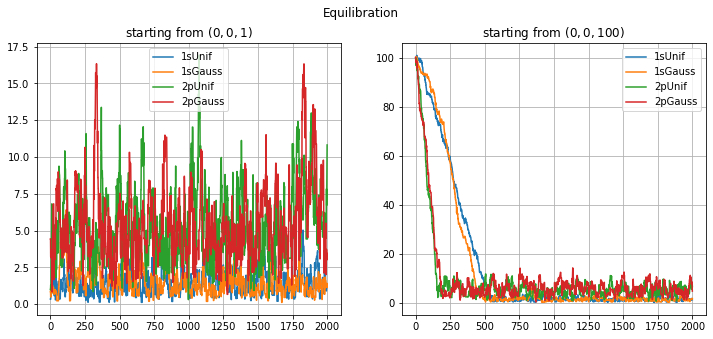

In [2]:
fig, axs = plt.subplots(1,2, figsize = (12, 5))
fig.suptitle('Equilibration')
simulations = ['1sUnif', '1sGauss', '2pUnif', '2pGauss']
for simul in simulations:
    data_close = np.loadtxt('close/pos' + simul + '.dat', usecols=3)
    axs[0].plot(data_close, label=simul)
    
    data_far = np.loadtxt('far/pos' + simul + '.dat', usecols=3)
    axs[1].plot(data_far, label=simul)
axs[0].legend()
axs[0].set_title(r'starting from $(0,0,1)$')
axs[0].grid()
axs[1].legend()
axs[1].set_title('starting from $(0,0,100)$')
axs[1].grid()

plt.show()

Dai grafici vedo che quando il sistema parte vicino all'origine è immediatamente equilibrato mentre quando parte lontano dall'origine, necessita di un tempo finito di equilibrazione. Non si notano differenze tra lo step uniforme e gaussiano.

D'ora in poi useremo sempre come punto di partenza (0,0,1).

### Taglia dei blocchi
Studiamo ora l'autocorrelazione delle serie di valori di $r$. Sceglieremo la dimensione del blocco di modo che i blocchi siano correlati tra loro solo superficialmente. Ovvero, solo le misure di blocchi diversi vicine ai "bordo" sono correlate.

In [3]:
from statsmodels.tsa.stattools import acf

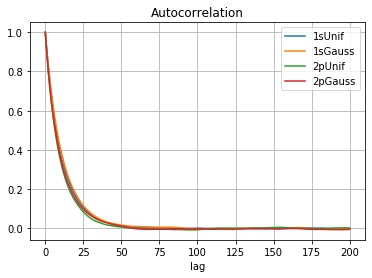

In [4]:
simulations = ['1sUnif', '1sGauss', '2pUnif', '2pGauss']

plt.title('Autocorrelation')
for simul in simulations:
    r = np.loadtxt('data/pos' + simul + '.dat', usecols=3)
    acorr = acf(r, nlags=200, fft=True) #calculate autocorr
    plt.plot(acorr, label=simul)
plt.legend()
plt.xlabel('lag')
plt.grid()
plt.show()

Notiamo un andamento pressochè identico tra tutte le simulazioni. Prenderemo dei blocchi grossi __100 step__

### Stima di $\langle r \rangle$
Effettuo il data blocking, con blocchi di dimensione 100 step,sulle misure di $r$.

Ricordiamo i valori attesi
$$
\left\langle r \right\rangle_{\Psi_{1,0,0}} = \frac{3}{2}a_0
\quad
\left\langle r \right\rangle_{\Psi_{2,1,0}} = 5 a_0
$$
</span>

In [5]:
def data_blocking(data, blocks):
    if blocks <=0:
        print("block_ave cannot run, please assign a positive number of blocks")
        return 0
    
    error = np.zeros(blocks)
    cumul_ave = np.zeros(blocks)
    block_ave = 0
    m_sum = 0
    m_sum2 = 0
    block_size = int(data.size/blocks)
    
    for i in range(blocks):
        block_sum = 0
        for j in range(block_size):
            block_sum += data[j+i*block_size]
        block_ave  = block_sum/block_size 
        m_sum += block_ave
        m_sum2 += block_ave**2
        cumul_ave[i] = m_sum/(i+1)
        if i==0:
            error[i]=0
        else:
            error[i] = math.sqrt( (m_sum2/(i+1) - (m_sum/(i+1))**2)/i )
    return cumul_ave, error

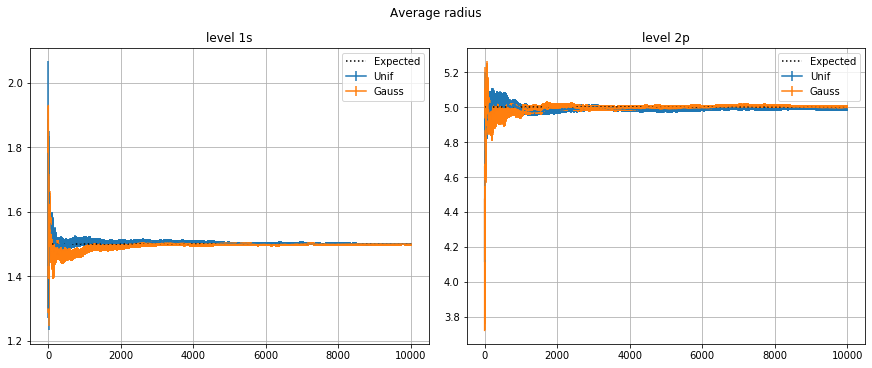

In [6]:
modes = ['Unif', 'Gauss']
levels = ['1s', '2p']
fig, axs = plt.subplots(1,2, figsize=(12,5), constrained_layout=True)
fig.suptitle('Average radius')
exp_val = [1.5, 5]
n_blocks = 10000
for i_lev, level in enumerate(levels):
    for mode in modes:
        data = np.loadtxt('data/pos' + level + mode + '.dat', usecols=3)
        r, err = data_blocking(data, n_blocks)
        axs[i_lev].errorbar(range(n_blocks), r, err, label=mode)
    axs[i_lev].hlines(exp_val[i_lev], 1, n_blocks, linestyles='dotted', label = 'Expected')
    axs[i_lev].set_title('level '+level)
    axs[i_lev].legend()
    axs[i_lev].grid()
plt.show()

Si osserva che con entrambi i metodi il valore simulato converge al valore atteso

### Probability density
Infine, visualizziamo con uno scatterplot la distribuzione di probabilità data dal modulo quadro della funzione d'onda. 

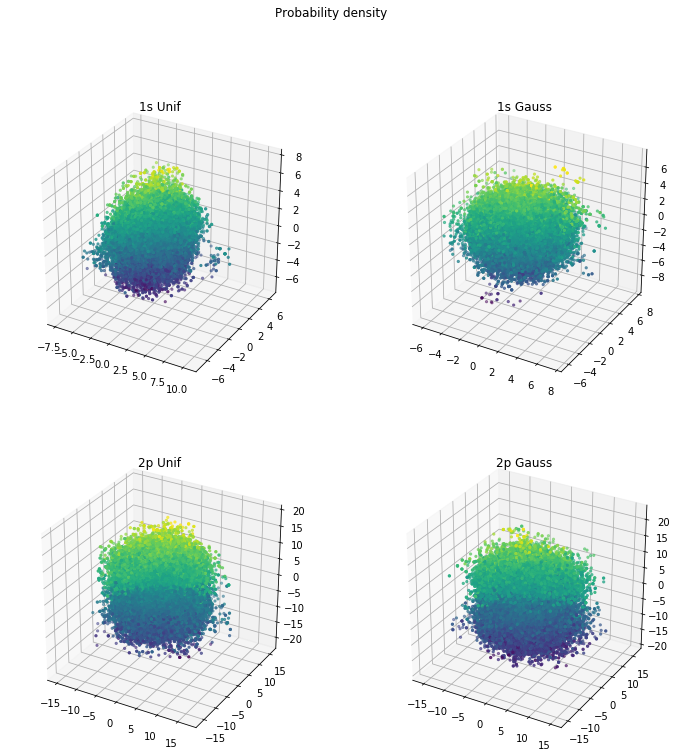

In [7]:
modes = ['Unif', 'Gauss']
levels = ['1s', '2p']
fig = plt.figure(figsize = (12,12))
fig.suptitle('Probability density')
for i_lev, level in enumerate(levels):
    for i_mode, mode in enumerate(modes):
        X,Y,Z = np.loadtxt('data/pos' + level + mode + '.dat', usecols=(0,1,2), unpack=True)
        ax = fig.add_subplot(2, 2, i_lev*2+i_mode+1, projection = "3d")
        ax.scatter(X, Y, Z, c=Z, marker='.')
        ax.set_title(level + ' ' + mode)
        
plt.show()

Anche qui, non si osservano differenze tra i due metodi: uniforme e gaussiano. La figura dell'1s, con i dati attuali, sembra più schiacciata ma si noti che la scala su uno degli assi è diversa.